In [1]:
from voyage.data import CityData
from voyage.main import *

In [2]:
CITY = "hong_kong"
OPPOSITE_CITY = "berlin"

In [3]:
city_data = CityData(CITY)
opposite_city_data = CityData(OPPOSITE_CITY)

In [4]:
city_map(city_data)

In [5]:
street_area_combine(city_data)

In [6]:
insta_wiki_scatter(city_data)

In [7]:
face_scatter(city_data)

In [8]:
tags_rate(city_data)

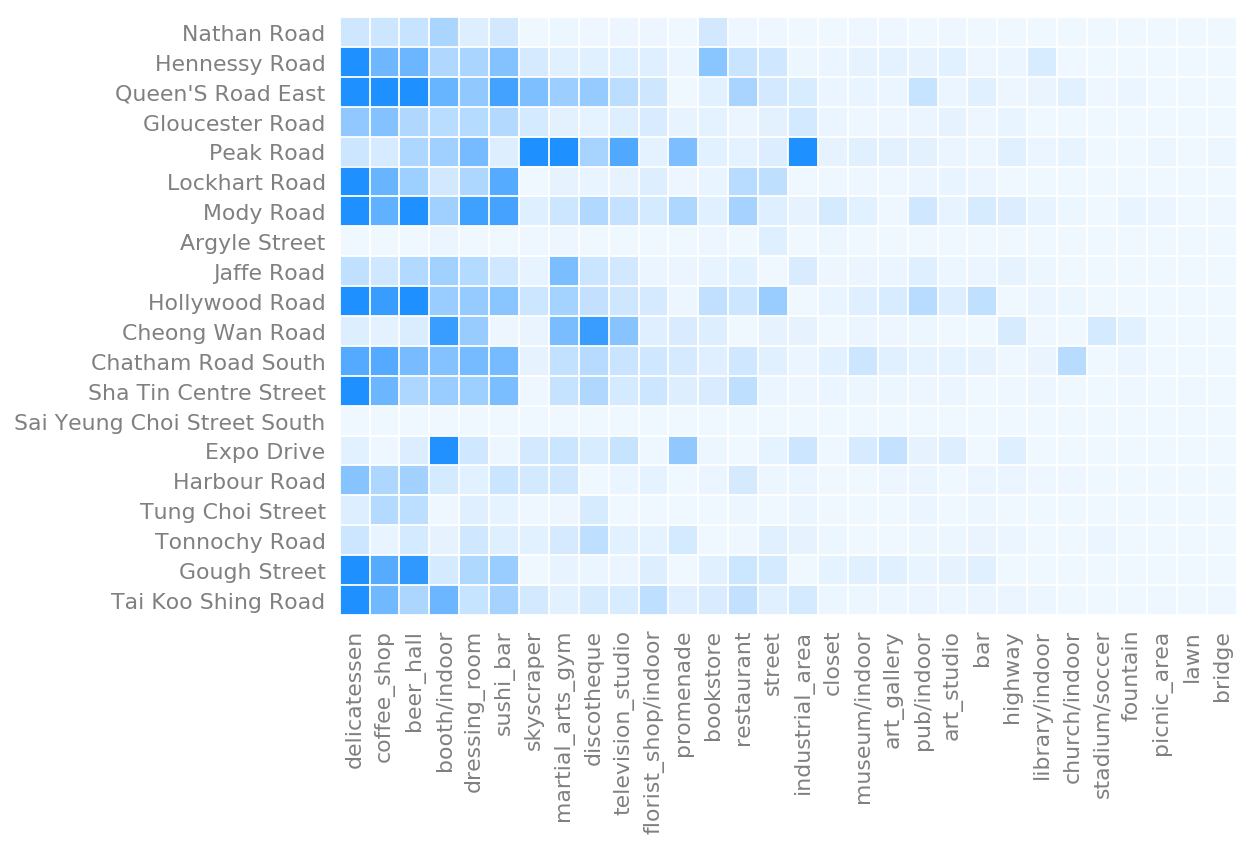

In [9]:
streets_features(city_data)

In [10]:
tagged_city_map(city_data)

In [11]:
locations_scatter(city_data, opposite_city_data)

In [12]:
tags_delta(city_data, opposite_city_data)